<a href="https://colab.research.google.com/github/sajacaros/bootcamp_colab/blob/main/test/%5BAI_Bootcamp_06%5DPytorch_2_0_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch 2.0

- 기존 버젼인 1.13보다 훨씬 더 Pythonic 해졌다.

- torch.compile의 발전으로 timm이나 Huggingface를 사용할 때 성능향상이 커졌다.

- GPU에서 병렬 연산 최적화를 통해서 큰 모델에서도 효율적으로 연산이 가능해졌다.


Reference : https://pytorch.org/blog/pytorch-2.0-release/

### CIFAR10 Classification

- pytorch 2.0을 이용하여, CIFAR10 이미지 분류 문제를 풀어봅니다.

1. CIFAR10 데이터를 불러오고, 기본적인 전처리를 수행합니다.

2. 학습을 수행할 모델을 정의합니다.

3. 학습에 사용할 loss function과 optimizer를 정의합니다.

4. 학습을 수행합니다.

5. 학습한 모델로 예측을 수행합니다.

In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from time import time
import os
from tqdm.auto import tqdm

# 파이토치 라이브러리와 필요한 모듈들을 불러옵니다.
import torch
import torchvision
from torchinfo import summary

In [ ]:
seed = 2023
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [ ]:
!nvidia-smi

Tue Oct 24 07:31:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |    883MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(torch.__version__)
print(torchvision.__version__)
print(os.cpu_count())

2.1.0+cu118
0.16.0+cu118
2


### 1. 전처리 함수 정의하기

In [ ]:
# 이미지 전처리에 필요한 transformation 함수를 정의
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # numpy array를 torch.FloatTensor로 변환, [0,255]->[0.0, 1.0]
    transforms.Normalize(mean=0.5, std=0.5)
])

In [ ]:
# torch에서 학습에 사용할 config variable들을 세팅합니다.
num_workers = 2
batch_size = 128
learning_rate = 0.1
epochs = 5

In [ ]:
from torch.utils.data import dataset
# Data Load
trainset = torchvision.datasets.MNIST(
    root='./',
    train=True, # trainset을 가져옴(60000장)
    download=True,
    transform=transform,
)
trainloader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
testset = torchvision.datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=transform,
)
testloader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
classes = (0,1,2,3,4,5,6,7,8,9,)

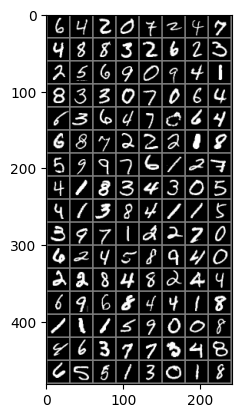

6 4 2 0 7 2 4 7 4 8 8 3 2 6 2 3 2 5 6 9 0 9 4 1 8 3 3 0 7 0 6 4 6 3 6 4 7 0 6 4 6 8 7 2 2 2 1 8 5 9 9 7 6 1 2 7 4 1 8 3 4 3 0 5 4 1 3 8 4 1 1 5 3 9 7 1 2 2 7 0 6 2 4 5 8 9 4 0 2 2 8 4 8 2 4 4 6 9 6 8 4 4 1 8 1 1 1 5 9 0 0 8 4 6 3 7 7 3 4 8 6 5 5 1 3 0 1 8


In [ ]:
# show images

def imshow(img):
    img = img/2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# iterator를 이용해서 데이터를 불러오게 만듭니다. (batch processing을 위해서)
dataiter = iter(trainloader)  # trainloader를 iterator로 선언.
images, labels = next(dataiter) # next 함수는 iterator의 반복 수행함.

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [ ]:
# shape을 확인합니다.
print(images.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


### 2. 학습 모델 정의


- 이미지 분류에 주로 쓰이는 모델은 CNN입니다.


- 처음에는 그냥 MLP(FCN)으로 구현을 하고, (나중에)Convolution 연산들을 추가해봅니다.


**모델 아키텍쳐**

- MLP : Input() -> Flatten() -> Linear() -> Linear() -> Linear()

In [ ]:
import torch.nn as nn

# 모델 구현에 필요한 레이어들을 정의합니다.
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # 3Layer-NN (input, hidden1, hidden2, output)
        self.fc1 = nn.Linear(in_features=1*28*28, out_features=512) # input => hidden1
        self.fc2 = nn.Linear(in_features=512, out_features=128) # hidden1 => hidden2
        self.fc3 = nn.Linear(in_features=128, out_features=10) # hidden2 => output
        self.relu = nn.ReLU() # activation layer
        self.softmax = nn.Softmax(dim=1) # (batch_size, output_layer_size)

    def forward(self, x):
        # feed-forward 연산을 구현합니다.
        x = torch.flatten(input=x, start_dim=1, end_dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = MLP().to(device)
model

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
!nvidia-smi

Tue Oct 24 07:31:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |    883MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
summary(model)
# 200960 -> (784+1) * 256
# 16448 -> (256+1) * 64
# 650 -> (64+1) * 10

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            401,920
├─Linear: 1-2                            65,664
├─Linear: 1-3                            1,290
├─ReLU: 1-4                              --
├─Softmax: 1-5                           --
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0

In [ ]:
# show params
for p in model.parameters():
  print(p.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


### 3. Optimizer와 Loss function 정의


- 학습에 가장 많이 사용하는 optimizer는 Adam입니다.


- 가장 기본이 되는 SGD(Stochastic Gradient Descent)와 Adam을 구현해서 비교해봅시다.

- multiclass classification에서 사용하는 loss function은 cross-entropy입니다.

In [ ]:
# import optimizers
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### 4. 학습

- pytorch에서는 학습을 위해서 train 함수와 test 함수를 직접 구현해야합니다.

- 처음에는 직접 for문을 통해서 batch 단위 학습 코드를 구현해봅시다.

In [ ]:
len(trainset), len(trainloader)

(60000, 469)

In [ ]:
start = time()

# for문을 이용하여 epoch마다 학습을 수행하는 코드를 작성합니다.
# 1 epoch : 전체 데이터를 다 학습시킨 경우
# 1 iteration : 1 weight update
# 1 epoch data size = batch_size * iterations
# 60000 = 600 x 100 --> weight update 100번(batch_size의 loss 평균으로..)
# 60000 = 128 x 469 --> weight update 469번(batch_size의 loss 평균으로..)

# total iterations = epochs(5) x iterations(469)

for epoch in tqdm(range(epochs)):
  n_correct = 0
  n_loss = 0
  for idx, data in enumerate(trainloader):
    optimizer.zero_grad()

    ### fee forward
    if torch.cuda.is_available():
      images, labels = data[0].to(device), data[1].to(device) # GPU version
    else:
      images, labels = data[0], data[1] # CPU version

    outputs = model(images) # forward
    loss = criterion(outputs, labels) # compute loss
    # if idx % 100 == 0 or idx % 450 == 0:
      # print(f"epoch {epoch} : {idx:4} iteration -> {loss.item():.4f}") # loss value

    n_loss += loss.item()
    n_correct += (torch.max(outputs, dim=1)[1] == labels).sum()

    ### back propagation
    loss.backward() # loss를 가지고 gradient 계산
    optimizer.step() # optimizer를 이용해서 wegith를 update 수행

  print(f'{epoch=}, train acuracy : {n_correct/len(trainset):.4f}, train loss : {n_loss/len(trainloader):.4f}')

end = time()

print("Training Done.")
print(f"Elasped Time : {end-start:.4f} secs., loss : {loss.item():.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch=0, train acuracy : 0.5866, train loss : 1.9179
epoch=1, train acuracy : 0.8848, train loss : 1.5965
epoch=2, train acuracy : 0.9053, train loss : 1.5663
epoch=3, train acuracy : 0.9137, train loss : 1.5549
epoch=4, train acuracy : 0.9215, train loss : 1.5462
Training Done.
Elasped Time : 81.6493 secs., loss : 1.5230


In [ ]:
!pip install graphviz torchview

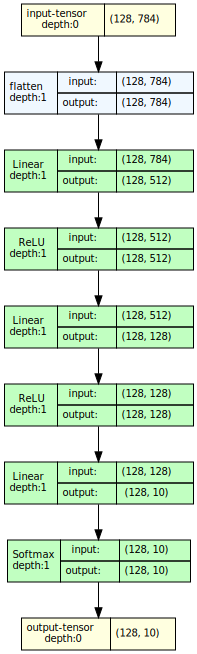

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(batch_size, 28*28))
model_graph.visual_graph

### 5. 학습한 모델로 예측

- 학습한 model을 가지고 test data를 예측합니다.

- 예측 성능을 높이는 것이 학습의 목표이기 때문에, 학습되는 상황과 비교하여 잘 나오는 것을 확인해야 합니다.


- 예측도 직접 구현하여 확인할 수 있습니다.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
# 예측 연산은 출력된 결과값중에서 argmax를 찾는 방식으로 수행됩니다.
outputs = model(images.to(device))
preds = torch.max(outputs, dim=1)[1]
len(preds)
#outputs.shape # 4장의 데이터에 대해서 10개 숫자.

# or
print("Predicted: ", ' '.join(f'{classes[preds[j]]}' for j in range(batch_size)))

Predicted:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7 1 3 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9 1 7 3 7 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8 7 3 9 7 4 4 4 9 2 5 4 7 6 4 9 0 5


In [ ]:
# make prediction for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# weight update를 하지 않는 모드
with torch.no_grad():
  correct_sum = 0
  loss_sum = 0
  for idx, data in enumerate(testloader):
    x, labels = data[0].to(device), data[1].to(device)

    outputs = model(x)
    preds = torch.max(outputs, dim=1)[1]
    correct_sum += (preds == labels).sum()
    loss_sum += criterion(outputs, labels)

    for label, pred in zip(labels, preds):
      total_pred[label.item()] +=  1
      if label == pred:
        correct_pred[label.item()] += 1

  print(f'accuracy : {correct_sum/len(testset)}, loss : {loss_sum/len(testloader)}')




for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5} is {accuracy:.1f} %, size : {total_pred[classname]}")

accuracy : 0.9251999855041504, loss : 1.5420864820480347
Accuracy for class:     0 is 97.6 %, size : 980
Accuracy for class:     1 is 97.8 %, size : 1135
Accuracy for class:     2 is 91.4 %, size : 1032
Accuracy for class:     3 is 94.6 %, size : 1010
Accuracy for class:     4 is 92.3 %, size : 982
Accuracy for class:     5 is 85.2 %, size : 892
Accuracy for class:     6 is 96.3 %, size : 958
Accuracy for class:     7 is 94.2 %, size : 1028
Accuracy for class:     8 is 85.6 %, size : 974
Accuracy for class:     9 is 88.9 %, size : 1009


In [ ]:
len(testset)

10000

In [ ]:
sum([class_[1] for class_ in correct_pred.items()]) / 10000 * 100

92.52

### Go Further?

- GPU를 켜서 수행해봅시다.


- 사실 딥러닝을 할 때는 무조건 GPU를 사용합니다.


- pytorch에서 GPU를 사용하기 위해서는 device를 정의한 후, device에 연산에 필요한 모델, 데이터를 보내는 것으로 자동으로 GPU acceleration이 일어나게 만듭니다.


- **.to(device)** 로 해당 모델과 데이터를 GPU로 보낼 수 있습니다.

In [ ]:
# cuda가 있다는건 nvidia GPU가 있는 session을 쓰고 있다는 뜻.
